In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data, plotting
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/933149977.py:15: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, masking, input_data, plotting


In [3]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps")


Loading Craddock atlas from local file...
Atlas loaded: dset/craddock2012_tcorr05_2level_270_2mm.nii
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 1

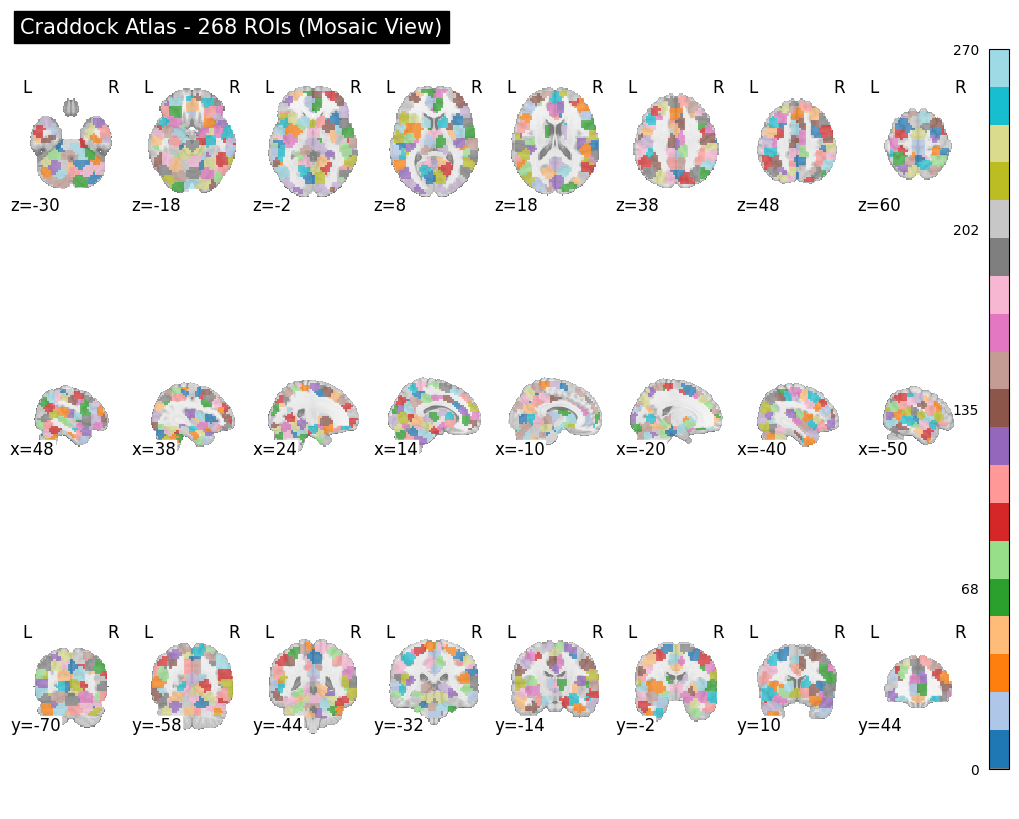


Plotting regions (atlas value 269)...


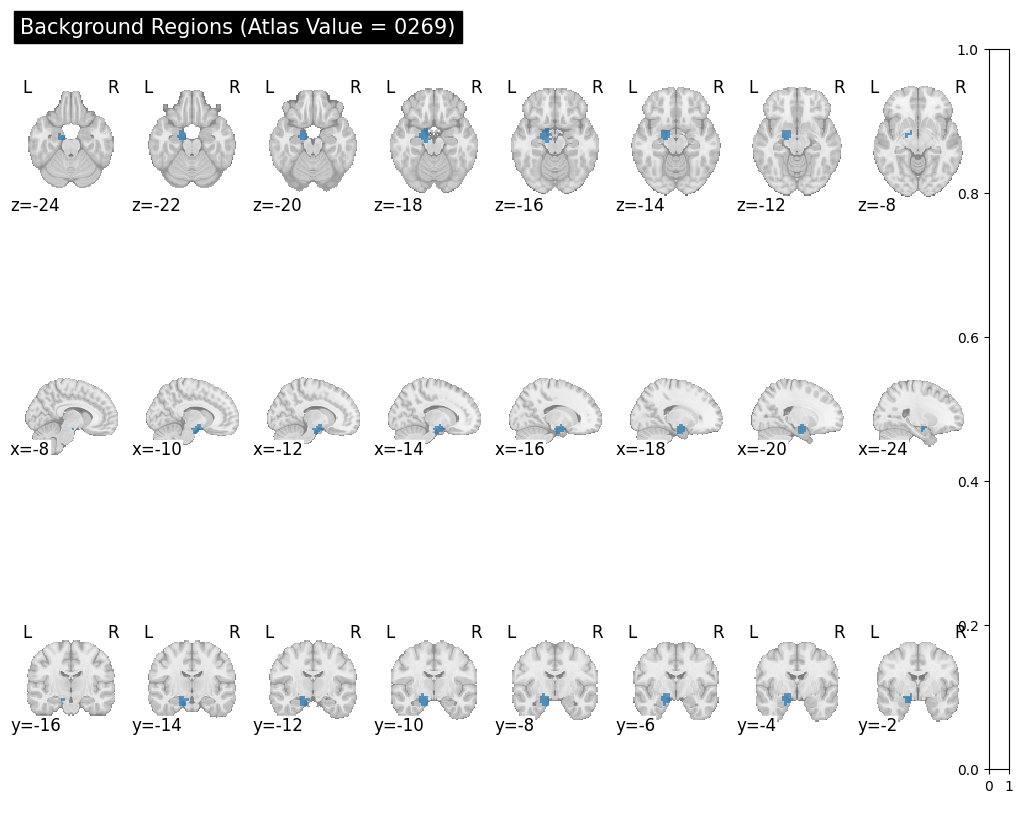

Background Statistics:
• Background voxels: 755,557
• Total voxels: 902,629
• Background coverage: 83.7%
Atlas Statistics:
• Total ROIs: 268
• Label range: 1 - 270
• Brain voxels: 147,072
• Mean ROI size: 548.8 voxels
• Std ROI size: 106.6 voxels
• Min ROI size: 216 voxels
• Max ROI size: 848 voxels
• Atlas coverage: 16.3%


In [4]:
# Load Craddock atlas from local file
print("Loading Craddock atlas from local file...")

# Path to the unzipped atlas file
atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")

print(f"Atlas loaded: {atlas_filename}")

# Load the atlas to check its properties
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

# Get unique ROI labels (excluding background/0)
unique_labels = np.unique(atlas_data)
print(unique_labels)
unique_labels = unique_labels[unique_labels != 0]  # Remove background
n_rois = len(unique_labels)

print(f"Atlas shape: {atlas_data.shape}")
print(f"Number of ROIs: {n_rois}")
print(f"ROI labels range: {unique_labels.min()} to {unique_labels.max()}")


print(f"\nPlotting Craddock atlas...")

# Create figure
fig = plt.figure(figsize=(10, 8))

# Plot Mosaic view only
display = plotting.plot_roi(
    atlas_img,
    title=f'Craddock Atlas - {n_rois} ROIs (Mosaic View)',
    display_mode='mosaic',
    cut_coords=8,
    colorbar=True,
    cmap='tab20',
    figure=fig
)

plt.show()

# Plot  regions (atlas value 269)
print(f"\nPlotting regions (atlas value 269)...")

# Create a binary mask for background regions (value = 269)
background_data = np.where(atlas_data == 270, 1, 0)
background_img = nib.Nifti1Image(background_data, atlas_img.affine, atlas_img.header)

# Create figure for background
fig = plt.figure(figsize=(10, 8))

# Plot background regions
display = plotting.plot_roi(
    background_img,
    title='Background Regions (Atlas Value = 0269)',
    display_mode='mosaic',
    cut_coords=8,
    colorbar=True,
    cmap='tab20',
    figure=fig
)

plt.show()

# Background statistics
background_voxels = np.sum(atlas_data == 0)
total_voxels = np.prod(atlas_data.shape)
background_percentage = (background_voxels / total_voxels) * 100

print(f"Background Statistics:")
print(f"• Background voxels: {background_voxels:,}")
print(f"• Total voxels: {total_voxels:,}")
print(f"• Background coverage: {background_percentage:.1f}%")

# Create a detailed summary 
roi_sizes = []
for label in unique_labels:
    roi_size = np.sum(atlas_data == label)
    roi_sizes.append(roi_size)
brain_mask = atlas_data > 0
total_brain_voxels = np.sum(brain_mask)
atlas_coverage = (np.sum(atlas_data > 0) / np.prod(atlas_data.shape)) * 100


# Summary statistics
stats_text = f"""Atlas Statistics:
• Total ROIs: {n_rois}
• Label range: {unique_labels.min():.0f} - {unique_labels.max():.0f}
• Brain voxels: {total_brain_voxels:,}
• Mean ROI size: {np.mean(roi_sizes):.1f} voxels
• Std ROI size: {np.std(roi_sizes):.1f} voxels
• Min ROI size: {np.min(roi_sizes)} voxels
• Max ROI size: {np.max(roi_sizes)} voxels
• Atlas coverage: {atlas_coverage:.1f}%"""

print(stats_text)


In [5]:
# Create masker for extracting time series from ROIs
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  #z-scores the time series
    memory='nilearn_cache',
    verbose=1
)

In [6]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "episode_2": [1, 2, 3, 4, 5, 6, 7]  # Available runs for episode 2
    }
    # Add other participants as needed
}


In [7]:
# Extract BOLD time series and create z-scored participant matrices

# Initialize storage for participant-level matrices
all_participant_matrices = {}

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    participant_timeseries = []
    
    for episode_key, run_numbers in episodes.items():
        ep_num = int(episode_key.split('_')[1])
        
        print(f"\nProcessing Episode {ep_num} with {len(run_numbers)} runs...")
        
        for run_num in run_numbers:
            print(f"  Processing run {run_num}...")
            
            TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
            
            # Construct the filename - note that run number is NOT zero-padded
            task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
            task_filepath = TASK_DIR / task_filename


            # Extract time series from 268 ROIs
            print(f"    Extracting time series from {task_filepath.name}...")
            time_series = masker.fit_transform(task_filepath)
                
            print(f"    Time series shape: {time_series.shape} (TRs x ROIs)")
                
            # Store z-scored time series for this run
            participant_timeseries.append(time_series)
                

    if participant_timeseries:
        # Concatenate all runs for this participant
        print(f"\nConcatenating {len(participant_timeseries)} runs for {sub_id}...")
        participant_matrix = np.vstack(participant_timeseries)
        
        print(f"Final participant matrix shape: {participant_matrix.shape}")
        print(f"  - Total TRs across all runs: {participant_matrix.shape[0]}")
        print(f"  - Number of ROIs (Craddock): {participant_matrix.shape[1]}")
        
        # Store the participant-level matrix
        all_participant_matrices[sub_id] = participant_matrix
        
        # Save the participant matrix
        output_dir = OUT_DIR / "timeseries_matrices"
        output_dir.mkdir(parents=True, exist_ok=True)
        
        output_file = output_dir / f"{sub_id}_zscore_timeseries_matrix.npy"
        np.save(output_file, participant_matrix)
        print(f"Saved participant matrix to: {output_file}")
        
        # Also save as CSV for easier inspection
        output_csv = output_dir / f"{sub_id}_zscore_timeseries_matrix.csv"
        df_matrix = pd.DataFrame(participant_matrix, 
                                columns=[f"{unique_labels[i]}" for i in range(participant_matrix.shape[1])])
        df_matrix.to_csv(output_csv, index=False)
        print(f"Saved participant matrix (CSV) to: {output_csv}")
        


print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Processed {len(all_participant_matrices)} participants:")
for sub_id, matrix in all_participant_matrices.items():
    print(f"  {sub_id}: {matrix.shape[0]} TRs × {matrix.shape[1]} ROIs")





PROCESSING sub-Blossom

Processing Episode 2 with 7 runs...
  Processing run 1...
    Extracting time series from sub-Blossom_ses-02_task-strangerthings_run-1_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz...
[NiftiLabelsMasker.wrapped] Loading regions from <nibabel.nifti1.Nifti1Image object at 0x118e54ec0>
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Finished fit
    Time series shape: (318, 268) (TRs x ROIs)
  Processing run 2...
    Extracting time series from sub-Blossom_ses-02_task-strangerthings_run-2_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz...
[NiftiLabelsMasker.wrapped] Loading regions from <nibabel.nifti1.Nifti1Image object at 0x118e54ec0>
[NiftiLabelsMasker.wrapped] Resampling regions
[NiftiLabelsMasker.wrapped] Finished fit
    Time series shape: (255, 268) (TRs x ROIs)
  Processing run 3...
    Extracting time series from sub-Blossom_ses-02_task-strangerthings_run-3_part-mag_space-MNI152NLin2009cAsym


PROCESSING sub-Blossom
Loaded time series matrix: (2121, 268)
  - Time points (TRs): 2121
  - ROIs: 268

Determining optimal number of clusters...
  k=2: Inertia=462083.69, Silhouette=0.152
  k=3: Inertia=425647.62, Silhouette=0.106
  k=4: Inertia=402793.47, Silhouette=0.093
  k=5: Inertia=384758.09, Silhouette=0.087
  k=6: Inertia=373622.22, Silhouette=0.080
  k=7: Inertia=364701.38, Silhouette=0.073
  k=8: Inertia=357427.62, Silhouette=0.067
  k=9: Inertia=350835.06, Silhouette=0.065
  k=10: Inertia=344894.41, Silhouette=0.063
  k=11: Inertia=340258.81, Silhouette=0.063
  k=12: Inertia=335826.62, Silhouette=0.061
  k=13: Inertia=332120.38, Silhouette=0.062
  k=14: Inertia=327913.31, Silhouette=0.061
  k=15: Inertia=324670.06, Silhouette=0.060
  k=16: Inertia=320485.69, Silhouette=0.064
  k=17: Inertia=317235.31, Silhouette=0.062
  k=18: Inertia=314285.12, Silhouette=0.064
  k=19: Inertia=311662.44, Silhouette=0.064
  k=20: Inertia=309552.62, Silhouette=0.062


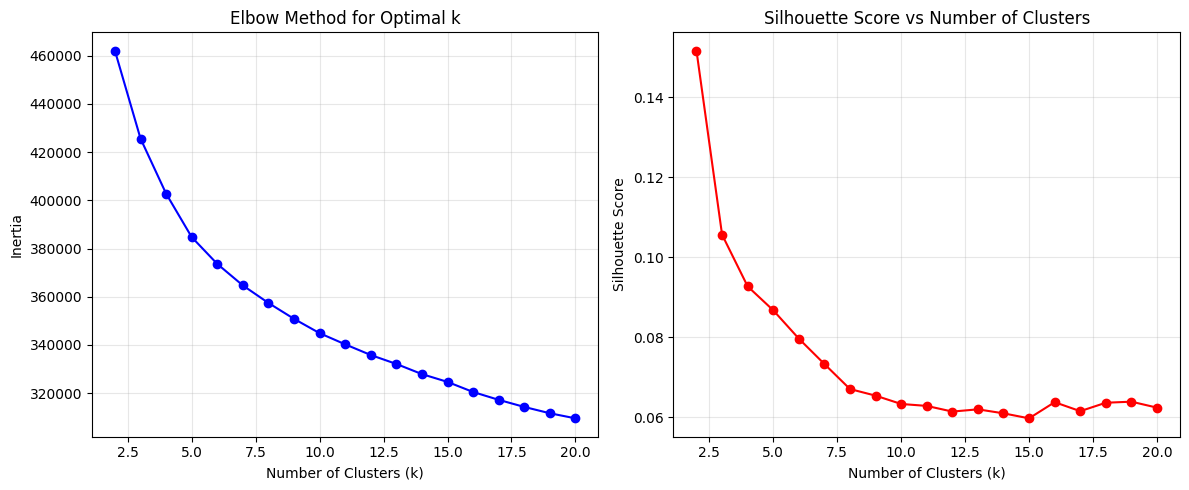


Elbow method results:
  - Optimal number of clusters (elbow): 4
  - Silhouette score at elbow k: 0.093
  - Inertia at elbow k: 402793.47

For comparison:
  - Best silhouette k: 2
  - Best silhouette score: 0.152

Optimal number of clusters: 4
Silhouette score at optimal k: 0.093

Performing final k-means clustering with k=4 (elbow method)...
Clustering results:
  - Total time points: 2121
  - Number of clusters: 4
  - Cluster 0: 255 time points (12.0%)
  - Cluster 1: 539 time points (25.4%)
  - Cluster 2: 519 time points (24.5%)
  - Cluster 3: 808 time points (38.1%)

Saved cluster labels to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_labels.npy
Saved cluster centers (CAPs) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_centers.npy
Saved cluster labels (CSV) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_labels.csv
Saved cluster centers (CSV) to: dset/derivatives/caps/kmeans/sub-Blossom_cluster_centers.csv
Saved clustering metadata to: dset/derivatives/caps/kmeans/su

In [8]:
# Load saved time series matrices and perform k-means clustering

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*60}")
    
    timeseries_file = OUT_DIR / f"timeseries_matrices/{sub_id}_zscore_timeseries_matrix.npy"
    
    if timeseries_file.exists():
        # Load the participant time series matrix
        participant_matrix = np.load(timeseries_file)
        print(f"Loaded time series matrix: {participant_matrix.shape}")
        print(f"  - Time points (TRs): {participant_matrix.shape[0]}")
        print(f"  - ROIs: {participant_matrix.shape[1]}")
        
        # Determine optimal number of clusters using elbow method and silhouette score
        print("\nDetermining optimal number of clusters...")
        k_range = range(2, 21)  # Test 2 to 20 clusters
        inertias = []
        silhouette_scores = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(participant_matrix)
            
            inertias.append(kmeans.inertia_)
            sil_score = silhouette_score(participant_matrix, cluster_labels)
            silhouette_scores.append(sil_score)
            
            print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")
        
        # Plot elbow curve and silhouette scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Elbow plot
        ax1.plot(k_range, inertias, 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette score plot
        ax2.plot(k_range, silhouette_scores, 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score vs Number of Clusters')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal k based on elbow method
        # Calculate the rate of change (differences) in inertia
        inertia_diffs = np.diff(inertias)
        
        # Calculate the second derivative (rate of change of the rate of change)
        second_diffs = np.diff(inertia_diffs)
        
        # Find the elbow point - where the second derivative is maximum
        # (greatest change in the rate of decrease)
        elbow_idx = np.argmax(second_diffs) + 2  # +2 because we lost 2 points in double diff
        optimal_k = k_range[elbow_idx]
        
        # Also report the silhouette score for this k
        corresponding_silhouette = silhouette_scores[elbow_idx]
        
        print(f"\nElbow method results:")
        print(f"  - Optimal number of clusters (elbow): {optimal_k}")
        print(f"  - Silhouette score at elbow k: {corresponding_silhouette:.3f}")
        print(f"  - Inertia at elbow k: {inertias[elbow_idx]:.2f}")
        
        # For comparison, also show the k with best silhouette score
        best_sil_k = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)
        print(f"\nFor comparison:")
        print(f"  - Best silhouette k: {best_sil_k}")
        print(f"  - Best silhouette score: {max_silhouette:.3f}")
        
        print(f"\nOptimal number of clusters: {optimal_k}")
        print(f"Silhouette score at optimal k: {corresponding_silhouette:.3f}")
        
        # Perform final clustering with optimal k (from elbow method)
        print(f"\nPerforming final k-means clustering with k={optimal_k} (elbow method)...")
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        final_labels = final_kmeans.fit_predict(participant_matrix)
        
        # Get cluster information
        cluster_unique_labels, label_counts = np.unique(final_labels, return_counts=True)
        
        print(f"Clustering results:")
        print(f"  - Total time points: {len(final_labels)}")
        print(f"  - Number of clusters: {len(cluster_unique_labels)}")
        
        for i, (label, count) in enumerate(zip(cluster_unique_labels, label_counts)):
            percentage = (count / len(final_labels)) * 100
            print(f"  - Cluster {label}: {count} time points ({percentage:.1f}%)")
        
        # Save clustering results
        cluster_output_dir = OUT_DIR / "kmeans"
        cluster_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save cluster labels
        labels_file = cluster_output_dir / f"{sub_id}_cluster_labels.npy"
        np.save(labels_file, final_labels)
        print(f"\nSaved cluster labels to: {labels_file}")
        
        # Save cluster centers (CAPs)
        centers_file = cluster_output_dir / f"{sub_id}_cluster_centers.npy"
        np.save(centers_file, final_kmeans.cluster_centers_)
        print(f"Saved cluster centers (CAPs) to: {centers_file}")
        
        # Save cluster labels as CSV for easy inspection
        labels_csv_file = cluster_output_dir / f"{sub_id}_cluster_labels.csv"
        df_labels = pd.DataFrame({
            'timepoint': range(len(final_labels)),
            'cluster_label': final_labels
        })
        df_labels.to_csv(labels_csv_file, index=False)
        print(f"Saved cluster labels (CSV) to: {labels_csv_file}")
        
        # Save cluster centers (CAPs) as CSV for easy inspection
        centers_csv_file = cluster_output_dir / f"{sub_id}_cluster_centers.csv"
        
        # Get the atlas unique_labels from the global scope (from cell 3)
        # This ensures we use the actual Craddock atlas numbers as column names
        from pathlib import Path
        atlas_filename = Path("dset/craddock2012_tcorr05_2level_270_2mm.nii")
        atlas_img_temp = nib.load(atlas_filename)
        atlas_data_temp = atlas_img_temp.get_fdata()
        atlas_unique_labels = np.unique(atlas_data_temp)
        atlas_unique_labels = atlas_unique_labels[atlas_unique_labels != 0]  # Remove background
        
        df_centers = pd.DataFrame(
            final_kmeans.cluster_centers_,
            columns=[f"{atlas_unique_labels[i]}" for i in range(final_kmeans.cluster_centers_.shape[1])],
            index=[f"CAP_{i}" for i in range(final_kmeans.cluster_centers_.shape[0])]
        )
        df_centers.to_csv(centers_csv_file)
        print(f"Saved cluster centers (CSV) to: {centers_csv_file}")
        
        # Save clustering metadata
        metadata = {
            'n_clusters': optimal_k,
            'method': 'elbow',
            'silhouette_score': corresponding_silhouette,
            'inertia': final_kmeans.inertia_,
            'cluster_sizes': label_counts.tolist(),
            'total_timepoints': len(final_labels),
            'best_silhouette_k': best_sil_k,
            'max_silhouette_score': max_silhouette
        }
        
        metadata_file = cluster_output_dir / f"{sub_id}_clustering_metadata.txt"
        with open(metadata_file, 'w') as f:
            for key, value in metadata.items():
                f.write(f"{key}: {value}\n")
        print(f"Saved clustering metadata to: {metadata_file}")
        
        # Store results for further analysis
        globals()[f"{sub_id}_cluster_labels"] = final_labels
        globals()[f"{sub_id}_cluster_centers"] = final_kmeans.cluster_centers_
        globals()[f"{sub_id}_kmeans_model"] = final_kmeans
        
    else:
        print(f"ERROR: Time series file not found: {timeseries_file}")

print(f"\n{'='*60}")
print("CLUSTERING COMPLETE")
print(f"{'='*60}")


PREPARING VISUALIZATION DATA FOR sub-Blossom

DataFrame for cap 1:
  Unnamed: 0       1.0      2.0       3.0       4.0       5.0       6.0  \
0      CAP_0 -1.113394 -0.97685 -1.330256 -1.016661 -1.145407 -0.762046   

        7.0       8.0       9.0  ...     261.0     262.0     263.0     264.0  \
0 -1.000166 -0.644388 -1.307052  ... -0.982368 -0.867218 -0.928796 -1.298344   

      265.0     266.0     267.0     268.0     269.0    270.0  
0 -0.915397 -0.233457 -0.818494 -0.988775 -1.208929 -0.36259  

[1 rows x 269 columns]
Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_CAP_0.nii.gz


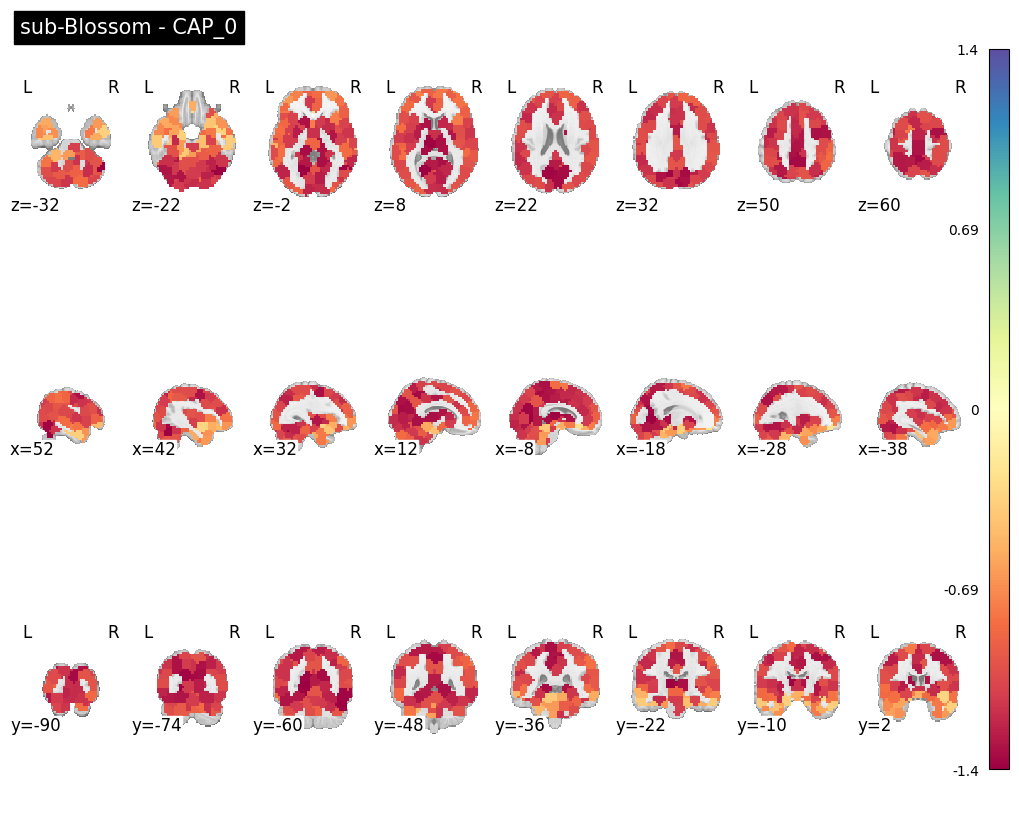


DataFrame for cap 2:
  Unnamed: 0       1.0       2.0       3.0       4.0      5.0       6.0  \
1      CAP_1  0.063667  0.373665 -0.036195  0.756467  0.32608  0.327641   

        7.0       8.0       9.0  ...     261.0     262.0     263.0     264.0  \
1  0.493337 -0.257005  0.024343  ...  0.462269 -0.189555  0.177767  0.181164   

      265.0     266.0    267.0     268.0     269.0     270.0  
1 -0.092925  0.730486  0.51369  0.158874  0.107286 -0.758368  

[1 rows x 269 columns]
Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_CAP_1.nii.gz


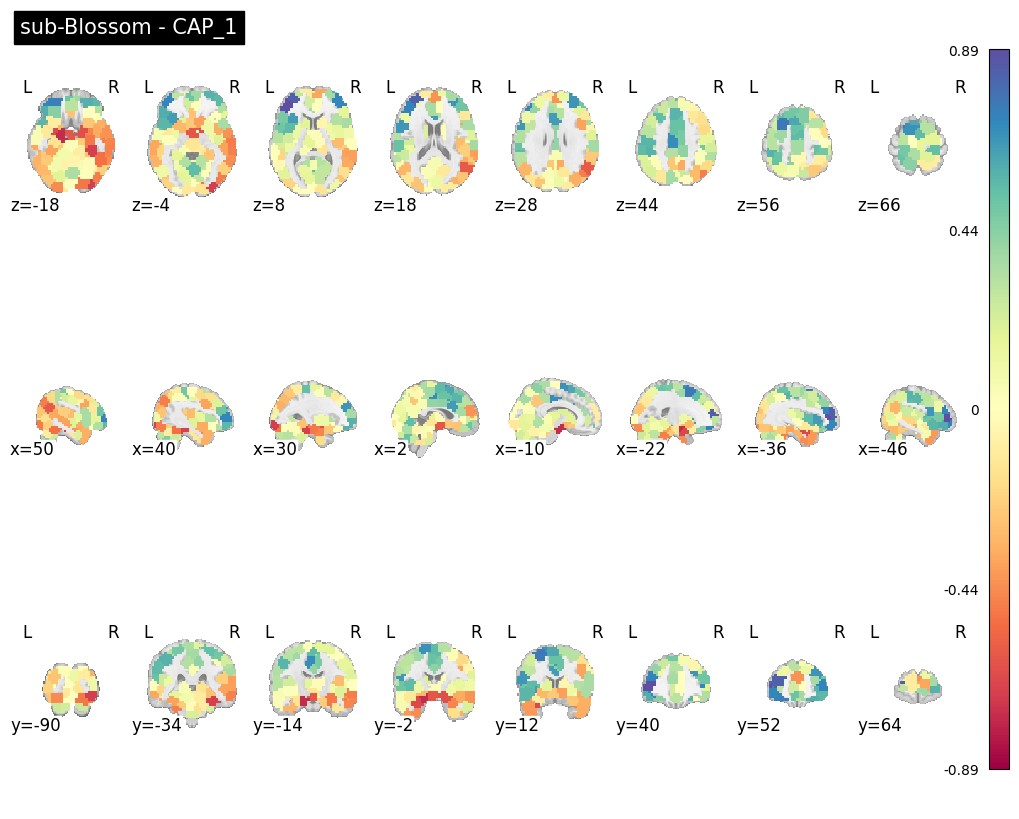


DataFrame for cap 3:
  Unnamed: 0       1.0       2.0       3.0       4.0       5.0       6.0  \
2      CAP_2  0.612385  0.648634  0.955849  0.585891  0.753354  0.434701   

       7.0       8.0       9.0  ...     261.0     262.0     263.0     264.0  \
2  0.67052  0.493234  0.875042  ...  0.568075  0.629889  0.527202  0.831851   

     265.0     266.0     267.0     268.0     269.0     270.0  
2  0.59237  0.014691  0.362731  0.620601  0.746859  0.311896  

[1 rows x 269 columns]
Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_CAP_2.nii.gz


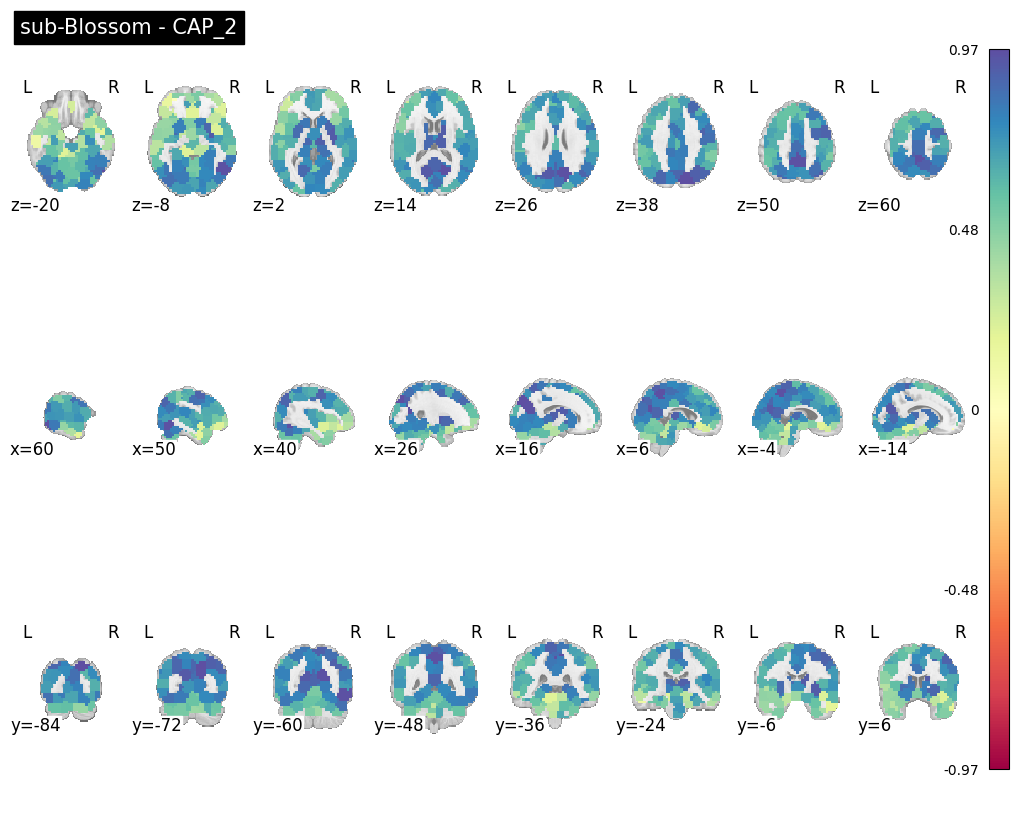


DataFrame for cap 4:
  Unnamed: 0       1.0      2.0       3.0       4.0      5.0      6.0  \
3      CAP_3 -0.084365 -0.35765 -0.169958 -0.560091 -0.33995 -0.25726   

        7.0       8.0       9.0  ...     261.0     262.0     263.0     264.0  \
3 -0.444122  0.058042 -0.165856  ... -0.363211 -0.004395 -0.164164 -0.245491   

      265.0     266.0    267.0    268.0     269.0     270.0  
3 -0.029674 -0.423081 -0.31733 -0.19257 -0.169773  0.419928  

[1 rows x 269 columns]
Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_CAP_3.nii.gz


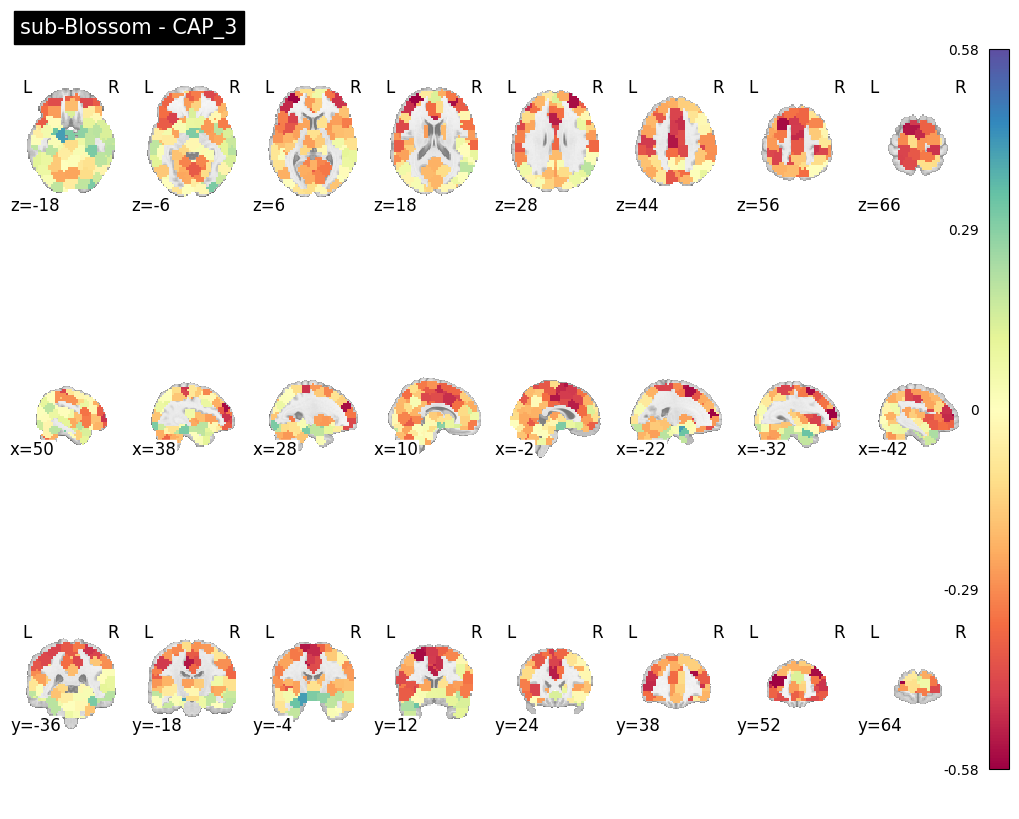

In [9]:
# Create DataFrames for CAP visualization data and plot them

masks_output_dir = OUT_DIR / "spatial_masks"
masks_output_dir.mkdir(parents=True, exist_ok=True)


for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PREPARING VISUALIZATION DATA FOR {sub_id}")
    print(f"{'='*60}")

    centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")

    # Loop over each CAP (row)
    for i, cap in centers_df.iterrows():
        cap_df = pd.DataFrame([cap], columns=centers_df.columns)
        print(f"\nDataFrame for cap {i+1}:")
        print(cap_df)

        # --- Prepare CAP visualization ---
        cap_name = cap_df.iloc[0, 0]  # e.g., 'CAP_0'
        z_values = cap_df.iloc[0, 1:].astype(float).values
        roi_labels = [float(c) for c in cap_df.columns[1:]]  # ROI labels (1.0, 2.0, ...)

        atlas_data = np.asanyarray(atlas_img.dataobj)
        mask_data = np.zeros_like(atlas_data, dtype=float)

        # Map z-values to atlas regions
        for roi, z in zip(roi_labels, z_values):
            mask_data[atlas_data == int(roi)] = z

        mask_img = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)

        mask_path = masks_output_dir / f"{sub_id}_{cap_name}.nii.gz"
        nib.save(mask_img, mask_path)
        print(f"Saved NIfTI: {mask_path}")

        # --- Plot CAP on Craddock atlas ---
        fig = plt.figure(figsize=(10, 8))
        vmin, vmax = np.nanmin(z_values), np.nanmax(z_values)
        vabs = max(abs(vmin), abs(vmax))

        display = plotting.plot_stat_map(
            mask_img,
            title=f"{sub_id} - {cap_name}",
            display_mode="mosaic",
            cut_coords=8,
            cmap="Spectral",
            colorbar=True,
            vmin=-vabs,
            vmax=vabs,
            figure=fig
        )

        plt.show()


PREPARING VISUALIZATION DATA FOR sub-Blossom
Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_weighted-90_CAP_0.nii.gz


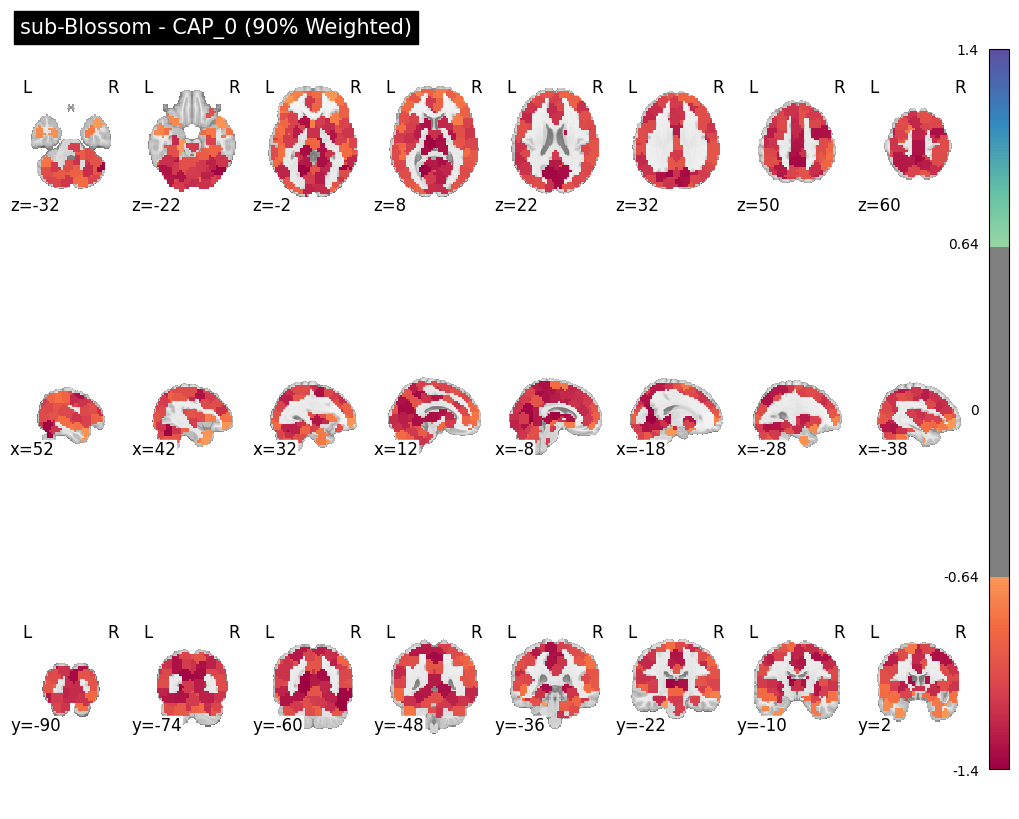

Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_weighted-90_CAP_1.nii.gz


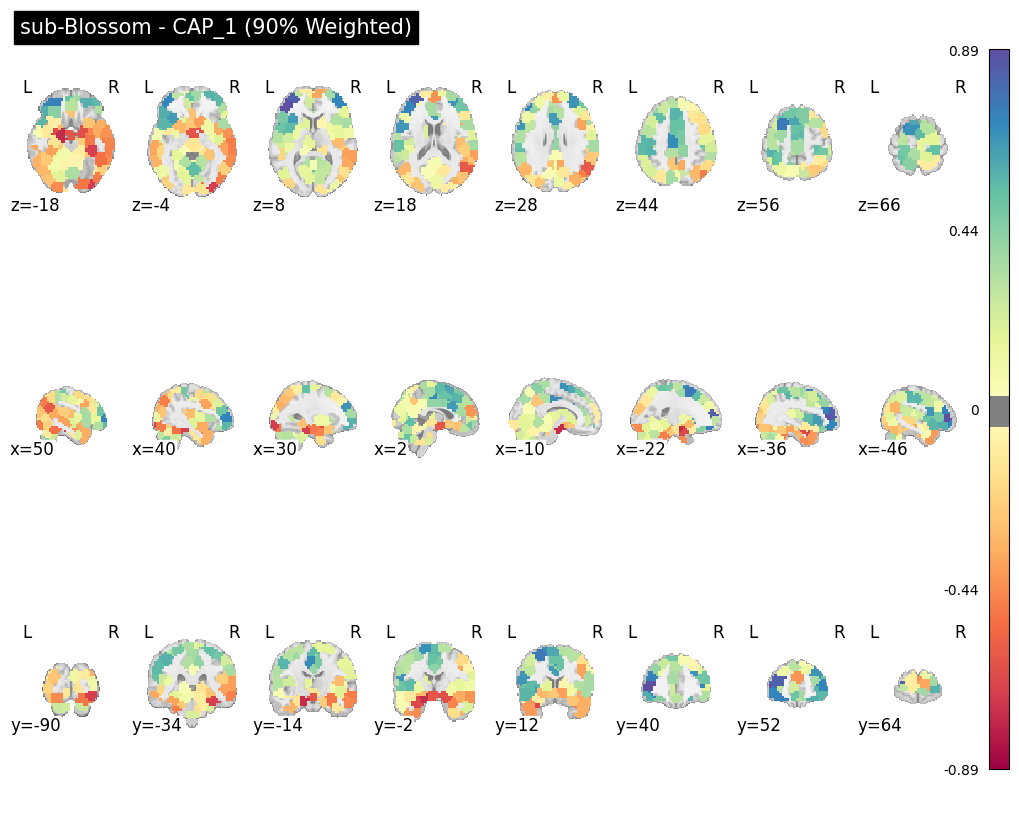

Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_weighted-90_CAP_2.nii.gz


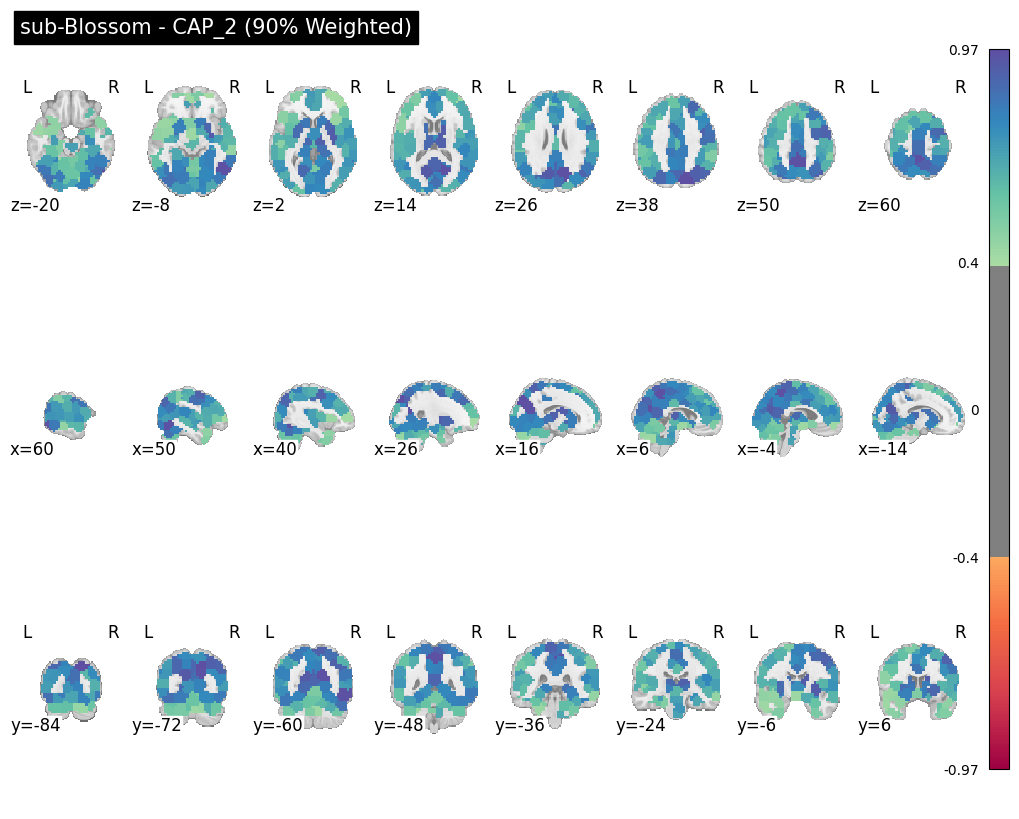

Saved NIfTI: dset/derivatives/caps/spatial_masks/sub-Blossom_weighted-90_CAP_3.nii.gz


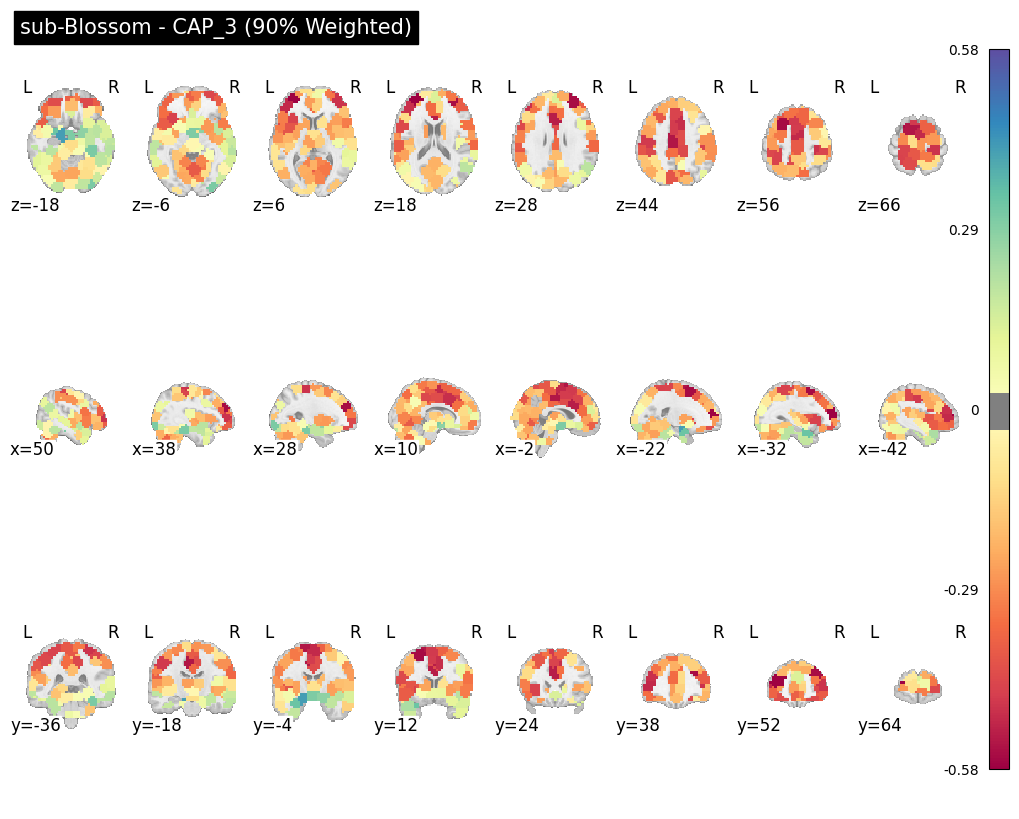

In [12]:
for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PREPARING VISUALIZATION DATA FOR {sub_id}")
    print(f"{'='*60}")

    centers_df = pd.read_csv(OUT_DIR / f"kmeans/{sub_id}_cluster_centers.csv")

    PCT_KEEP = 90.0  # keep top X% strongest parcels per CAP

    for i, cap in centers_df.iterrows():
        cap_df = pd.DataFrame([cap], columns=centers_df.columns)
        cap_name = cap_df.iloc[0, 0]
        roi_labels = [float(c) for c in cap_df.columns[1:]]
        z_vals = cap_df.iloc[0, 1:].astype(float).values

        # --- Compute threshold and save both original and thresholded ---
        orig_min, orig_max = np.nanmin(z_vals), np.nanmax(z_vals)
        vabs_full = max(abs(orig_min), abs(orig_max))  # full-range scaling
        thr = np.nanpercentile(np.abs(z_vals), 100.0 - PCT_KEEP)
        z_vals[np.abs(z_vals) < thr] = 0.0

        # --- Map thresholded z-values to atlas regions ---
        atlas_data = np.asanyarray(atlas_img.dataobj)
        mask_data = np.zeros_like(atlas_data, dtype=float)
        for roi, z in zip(roi_labels, z_vals):
            if z != 0.0:
                mask_data[atlas_data == int(roi)] = z

        mask_img = nib.Nifti1Image(mask_data, atlas_img.affine, atlas_img.header)
        mask_path = masks_output_dir / f"{sub_id}_weighted-{int(PCT_KEEP)}_{cap_name}.nii.gz"
        nib.save(mask_img, mask_path)
        print(f"Saved NIfTI: {mask_path}")

        # --- Plot CAP with colorbar reflecting full z-value range ---
        fig = plt.figure(figsize=(10, 8))
        plotting.plot_stat_map(
            mask_img,
            title=f"{sub_id} - {cap_name} ({int(PCT_KEEP)}% Weighted)",
            display_mode="mosaic",
            cut_coords=8,
            cmap="Spectral",
            threshold=thr,
            colorbar=True,
            vmin=-vabs_full,  # full original scale
            vmax=vabs_full,
            figure=fig
        )
        plt.show()



PLOTTING POSITIVE ACTIVATIONS FOR sub-Blossom
Found 4 CAP files

Processing: sub-Blossom_CAP_0.nii.gz
  Value range: [-1.375, -0.000]
  Positive values: 0 ROIs
  Negative values: 902629 ROIs
  No positive activations found in CAP_0
  Negative activation range: [-1.375, 0.000]
  Least negative value: -0.000000
  Using threshold: 0.000000 (absolute value)


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:94: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


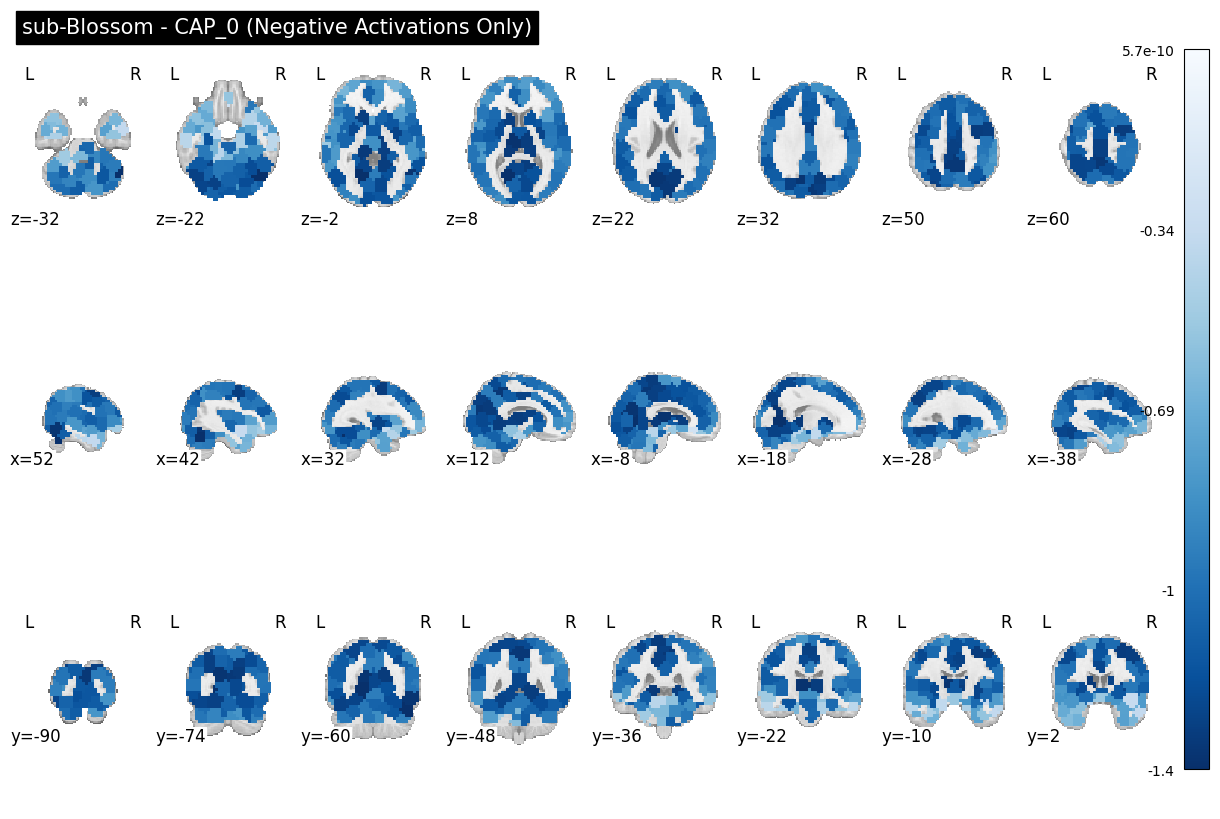


Processing: sub-Blossom_CAP_1.nii.gz
  Value range: [-0.758, 0.889]
  Positive values: 86688 ROIs
  Negative values: 815941 ROIs
  Positive activation range: [0.002, 0.889]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:53: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


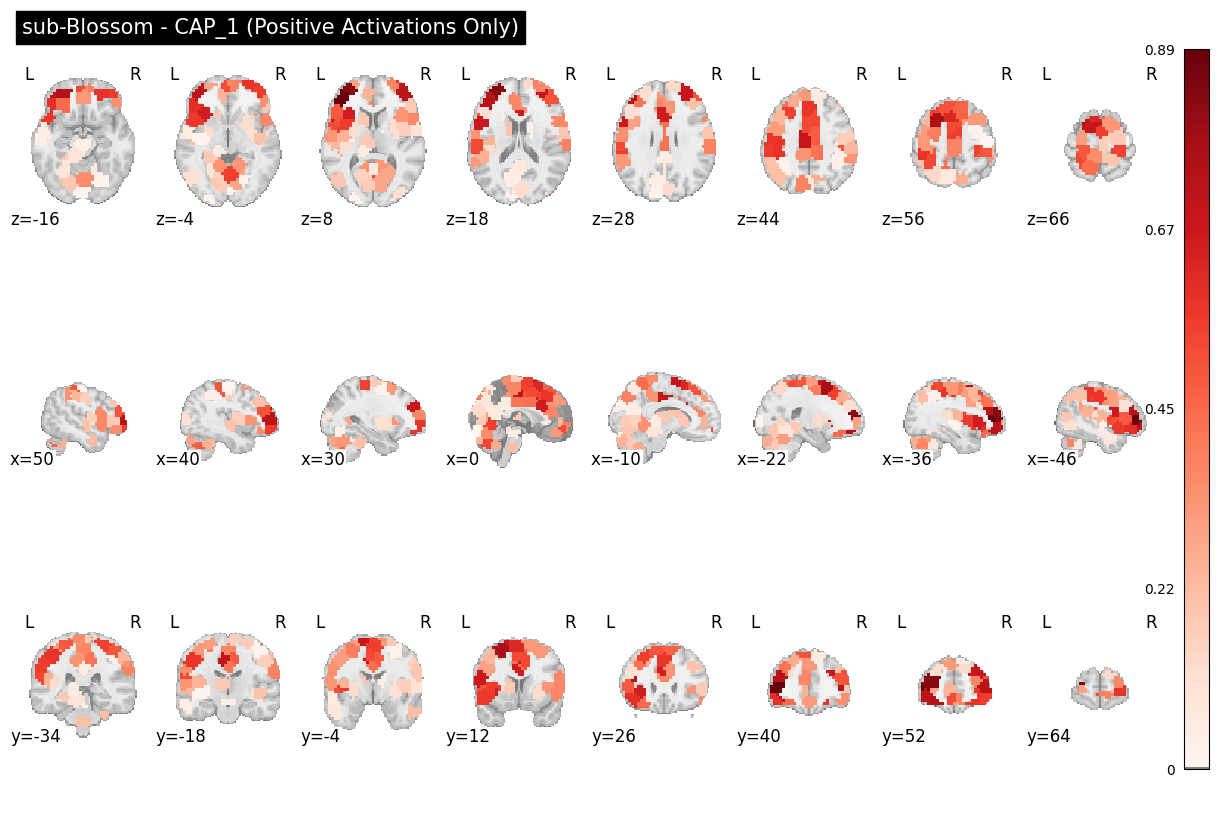

  Negative activation range: [-0.758, 0.000]
  Least negative value: -0.000003
  Using threshold: 0.000003 (absolute value)


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:94: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


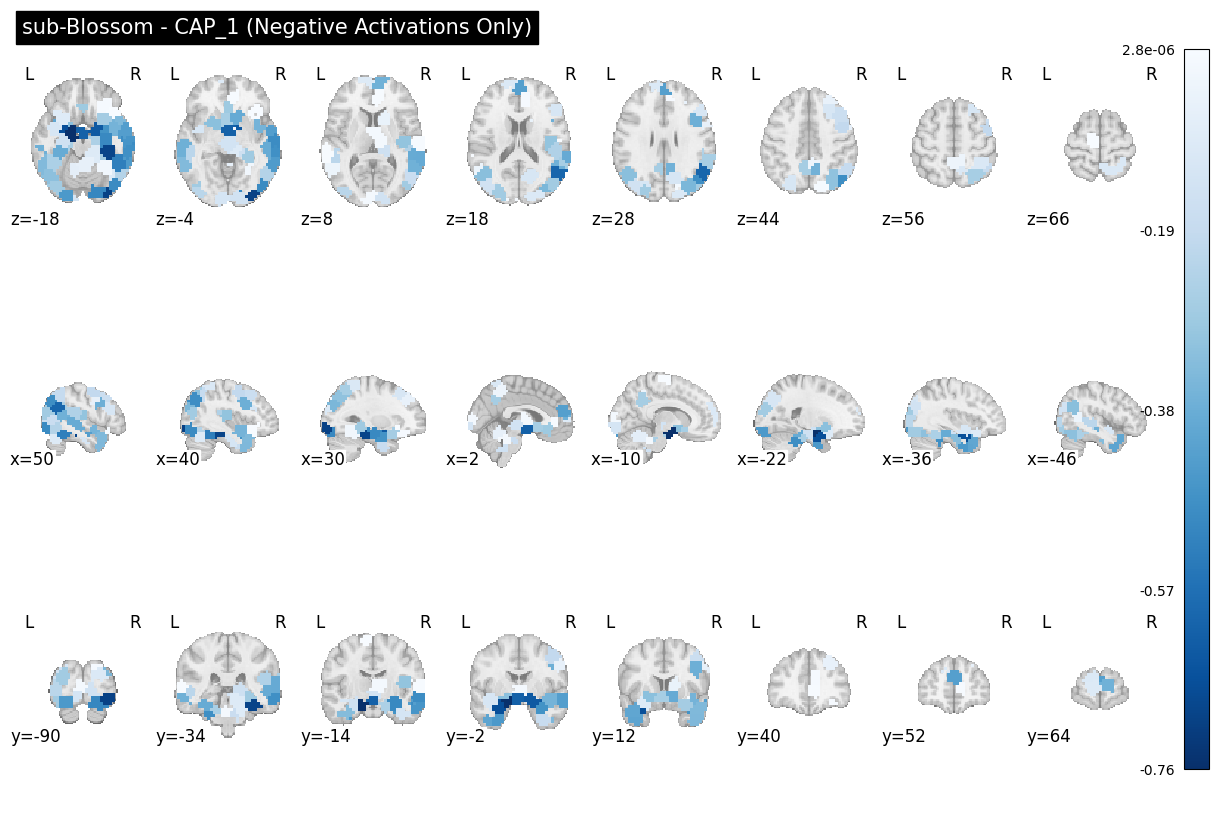


Processing: sub-Blossom_CAP_2.nii.gz
  Value range: [0.015, 0.968]
  Positive values: 147072 ROIs
  Negative values: 0 ROIs
  Positive activation range: [0.015, 0.968]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:53: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


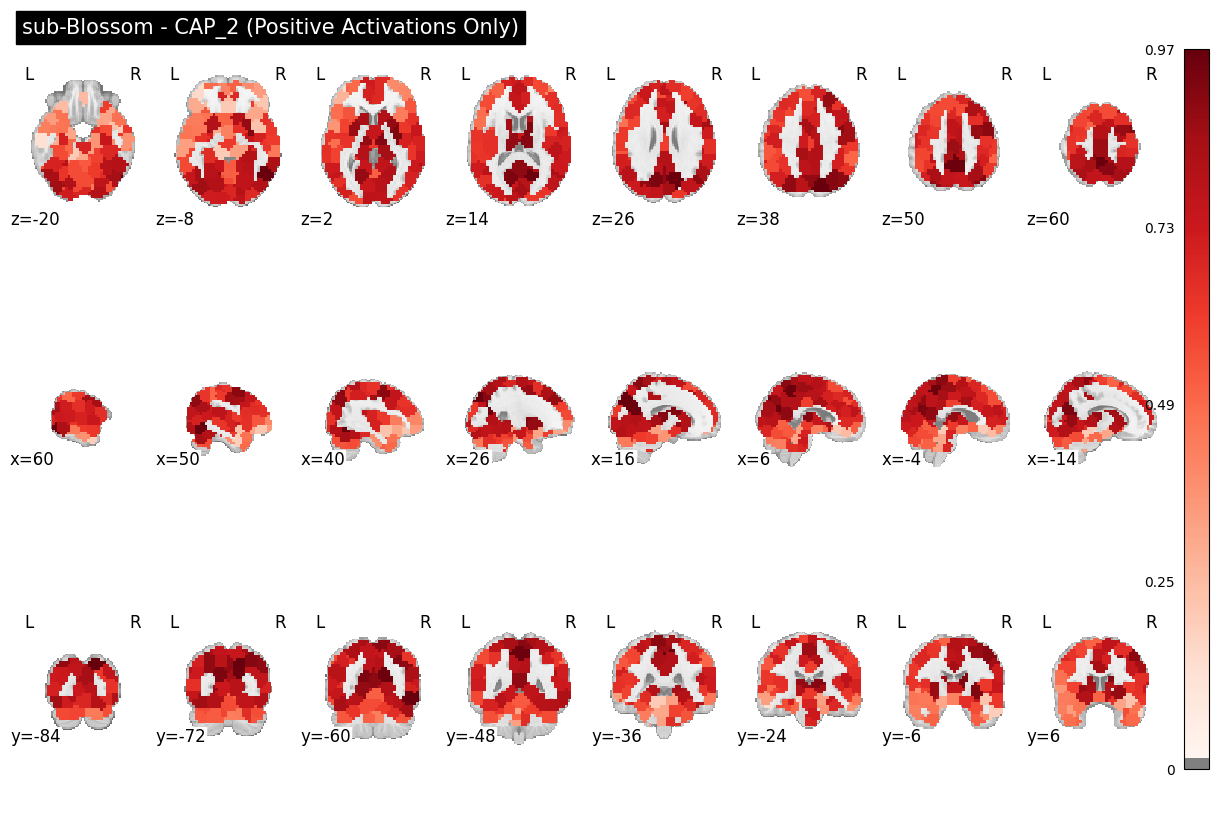

  No negative activations found in CAP_2

Processing: sub-Blossom_CAP_3.nii.gz
  Value range: [-0.578, 0.420]
  Positive values: 791189 ROIs
  Negative values: 111440 ROIs
  Positive activation range: [0.000, 0.420]


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:53: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


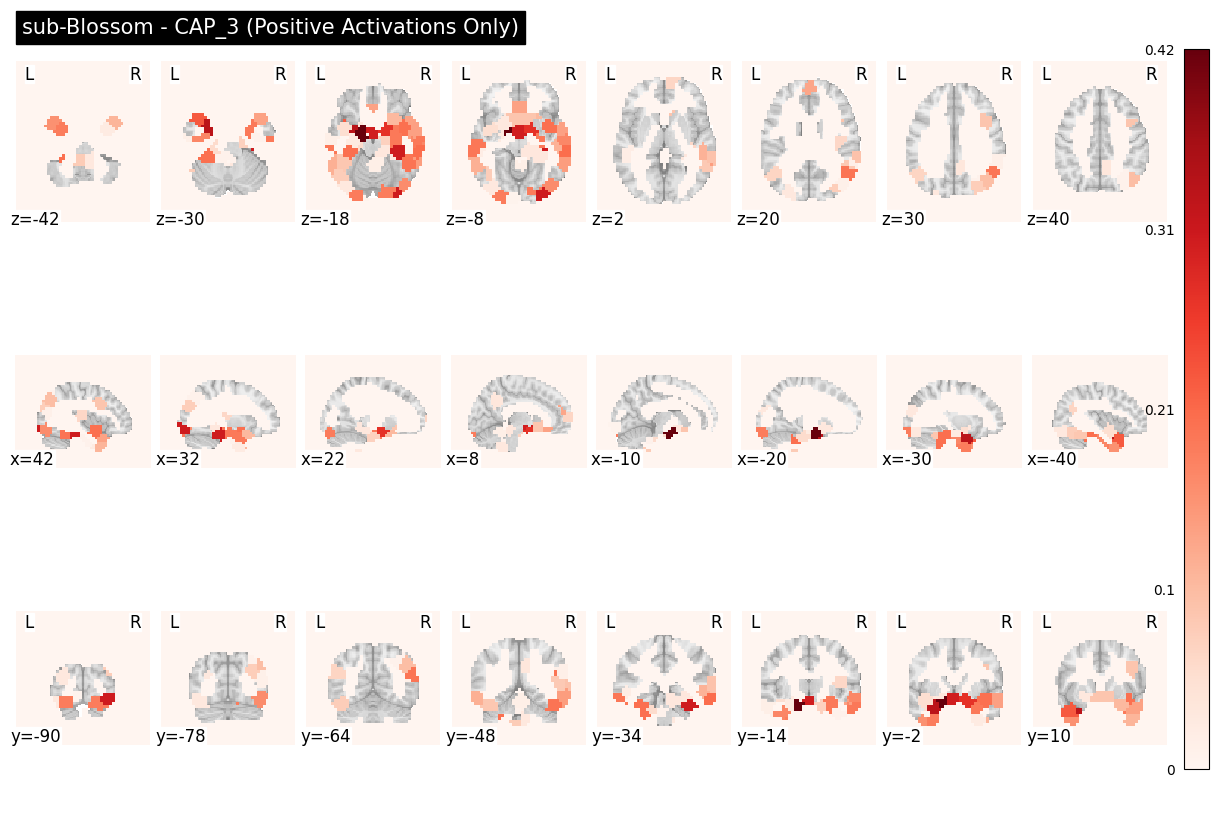

  Negative activation range: [-0.578, 0.000]
  Least negative value: -0.002294
  Using threshold: 0.002294 (absolute value)


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_6354/2792778702.py:94: UserWarning: kwargs['alpha']=0.8 detected in parameters.
Overriding with transparency=None.
To suppress this warning pass your 'alpha' value via the 'transparency' parameter.
  display = plotting.plot_stat_map(


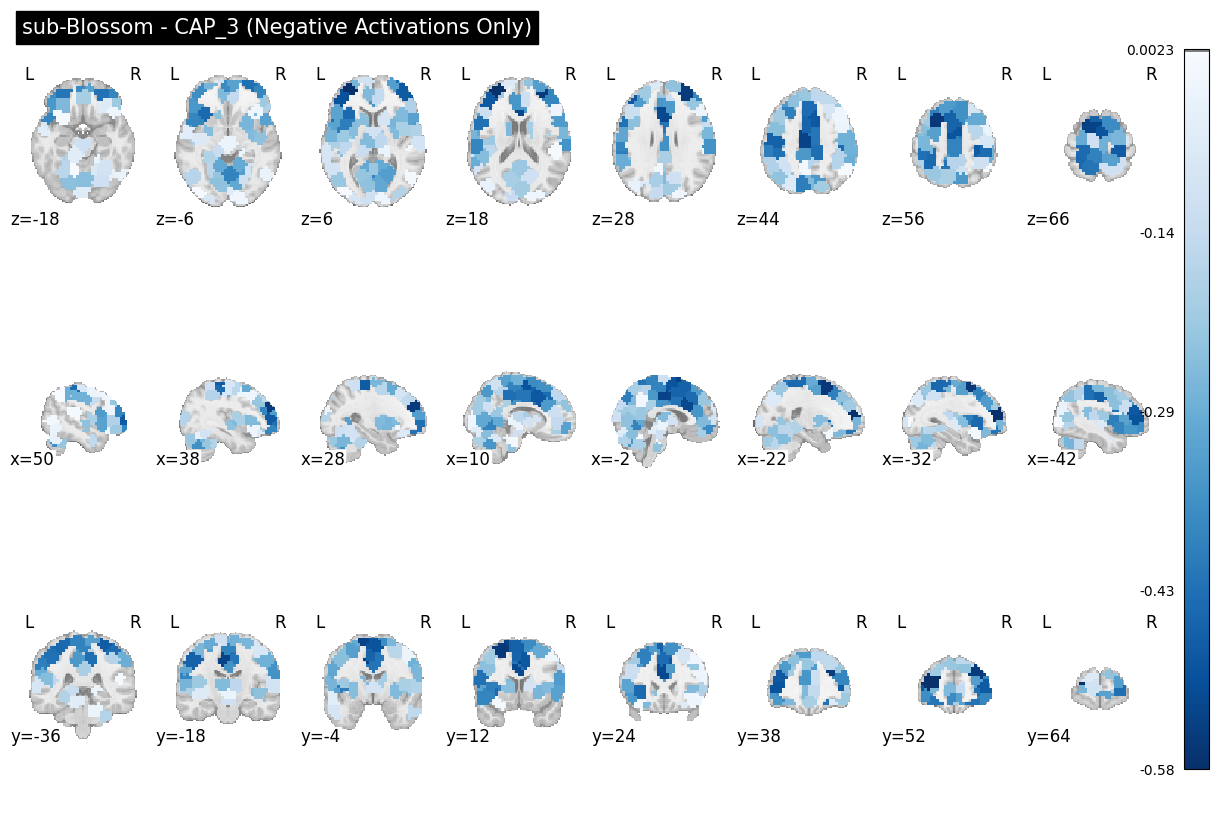

In [11]:
# Load NIfTI files and plot only positive activations

masks_dir = OUT_DIR / "spatial_masks"

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*60}")
    print(f"PLOTTING POSITIVE ACTIVATIONS FOR {sub_id}")
    print(f"{'='*60}")
    
    # Find all CAP NIfTI files for this subject
    cap_files = list(masks_dir.glob(f"{sub_id}_CAP_*.nii.gz"))
    cap_files.sort()  # Sort to ensure consistent order
    
    print(f"Found {len(cap_files)} CAP files")
    
    for cap_file in cap_files:
        print(f"\nProcessing: {cap_file.name}")
        
        # Load the NIfTI file
        cap_img = nib.load(cap_file)
        cap_data = cap_img.get_fdata()
        
        # Get the CAP name from filename
        cap_name = cap_file.stem.replace(f"{sub_id}_", "").replace(".nii", "")
        
        # Print value statistics
        all_values = cap_data[cap_data != 0]  # Exclude background
        if len(all_values) > 0:
            print(f"  Value range: [{all_values.min():.3f}, {all_values.max():.3f}]")
            print(f"  Positive values: {np.sum(all_values > 0)} ROIs")
            print(f"  Negative values: {np.sum(all_values < 0)} ROIs")
        
        # Create positive-only threshold mask
        # Only show values above 0 (positive activations)
        pos_threshold = 0.0
        
        # Create thresholded data
        pos_data = np.where(cap_data > pos_threshold, cap_data, 0)
        pos_img = nib.Nifti1Image(pos_data, cap_img.affine, cap_img.header)
        
        # Get positive values for colorbar scaling
        pos_values = pos_data[pos_data > 0]
        
        if len(pos_values) > 0:
            vmin_pos = pos_values.min()
            vmax_pos = pos_values.max()
            
            print(f"  Positive activation range: [{vmin_pos:.3f}, {vmax_pos:.3f}]")
            
            # Plot positive activations only
            fig = plt.figure(figsize=(12, 8))
            
            display = plotting.plot_stat_map(
                pos_img,
                title=f"{sub_id} - {cap_name} (Positive Activations Only)",
                display_mode="mosaic",
                cut_coords=8,
                cmap="Reds",  # Red colormap for positive values only
                colorbar=True,
                vmin=vmin_pos,
                vmax=vmax_pos,
                figure=fig,
                threshold=pos_threshold,  # Threshold at 0 to hide negative/zero values
                alpha=0.8
            )
            
            plt.show()
            
            
        else:
            print(f"  No positive activations found in {cap_name}")

        # Create negative-only threshold mask
        # Only show values below 0 (negative activations)
        
        # Get negative values for colorbar scaling and threshold calculation
        neg_values = cap_data[cap_data < 0]  # Only negative values

        if len(neg_values) > 0:
            vmin_neg = neg_values.min()
            vmax_neg = 0  # Set colorbar max to 0 for proper gradient from negative to 0
            
            # Find the least negative value (closest to 0) and use its absolute value as threshold
            least_negative = neg_values.max()  # This will be something like -0.000...
            neg_threshold = abs(least_negative)  # Convert to positive: 0.000...

            print(f"  Negative activation range: [{vmin_neg:.3f}, {vmax_neg:.3f}]")
            print(f"  Least negative value: {least_negative:.6f}")
            print(f"  Using threshold: {neg_threshold:.6f} (absolute value)")

            # Plot negative activations only
            fig = plt.figure(figsize=(12, 8))
            
            display = plotting.plot_stat_map(
                nib.Nifti1Image(cap_data, cap_img.affine, cap_img.header),
                title=f"{sub_id} - {cap_name} (Negative Activations Only)",
                display_mode="mosaic",
                cut_coords=8,
                cmap="Blues_r",  # Reversed blue colormap: lighter for less negative, darker for more negative
                colorbar=True,
                vmin=vmin_neg,
                vmax=vmax_neg,
                figure=fig,
                threshold=neg_threshold,  # Use absolute value of least negative as threshold
                alpha=0.8
            )
            
            plt.show()
            
            
        else:
            print(f"  No negative activations found in {cap_name}")

